# Setup and Imports

In [1]:
import sys
sys.path.insert(0,'../..')  # add project root to PATH

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# supress tensorflow depreciation warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# imports
from src.model import TinyYoloV3, train_test_split
from src.preprocessing import JSONUtil
from pathlib import Path
import numpy as np

Using TensorFlow backend.


In [5]:
data_path = '../../data/'
annotation_data = JSONUtil.read(Path(data_path, "Master.json"))
weights_path = '../../models/pre_trained_weights/tiny-yoloV3.h5'

# Model Training

### Set the Random Seeds
For deterministic execution.

In [6]:
# set seeds
tf.random.set_random_seed(4321)
np.random.seed(1459)
split_seed = 2345

### Load and Prepare the Data
Split the data into a test, validation and training set.

In [7]:
# Train-Test split
test_split = 0.1
train_val_data, test_data = train_test_split(annotation_data, test_split, split_seed)

# Train-Validation split
validation_split = 0.2
training_data, validation_data = train_test_split(train_val_data, validation_split, split_seed)

## Transfer Learning: Freezing followed by fine-tuning the whole model

### Define the Parameters

In [8]:
batch_size = 16
lr_freeze = 10**-2
lr_fine_tuning = 10**-6
epochs_freeze = 200
epochs_fine_tuning = 200

# Output paths
out_path_freeze = "model_0908.h5"
out_path_fine_tuning = '../../models/custom_trained_weights/model_1308_fine_tune.h5'
out_path_checkpoints ="weights.best.hdf5"

### Define the Callbacks

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0000001)
checkpoint = ModelCheckpoint(out_path_checkpoints, monitor='val_loss', verbose=0, save_best_only=True)
callbacks = [early_stopping, reduce_lr, checkpoint]

### Setup the Model

In [10]:
import keras.backend as K

# Set Keras to learning-mode --> fix constantly adapting batch-normalizations
K.set_learning_phase(1)

# Setup Model
model = TinyYoloV3(path = weights_path, pre_trained_weights = True)
model.replace_output_layers()
model.training_mode()

In [11]:
jittering_params = {
        "rotation_probability": 0.41196905003193296,
        "jittering_probability": 0.7701831052109321,
        "jittering_range": {
            "hue": 0.9058760880738045,
            "sat": 0.6951054624889021,
            "val": 0.8243935344646571
        }
    }

In [12]:
# freeze selected layers
model.freeze_all_but_output()
 
# start training (Transfer Learning)
history_freeze = model.train(training_data, validation_data, data_path, lr_freeze, batch_size, 
                             epochs_freeze, out_path=out_path_freeze, jittering_params = jittering_params,
                             callbacks = callbacks)


Train for 200 epochs on 926 samples with 232 validation samples and batch size 16.
Epoch 1/200
57/57 [==============================] - 27s 471ms/step - loss: 60.1667 - val_loss: 18.8437
Epoch 2/200
57/57 [==============================] - 22s 383ms/step - loss: 17.2372 - val_loss: 16.2969
Epoch 3/200
57/57 [==============================] - 22s 394ms/step - loss: 15.6213 - val_loss: 15.5245
Epoch 4/200
57/57 [==============================] - 23s 395ms/step - loss: 14.2641 - val_loss: 14.6396
Epoch 5/200
57/57 [==============================] - 22s 393ms/step - loss: 14.1435 - val_loss: 14.1891
Epoch 6/200
57/57 [==============================] - 22s 391ms/step - loss: 13.4206 - val_loss: 13.6441
Epoch 7/200
57/57 [==============================] - 23s 409ms/step - loss: 12.9689 - val_loss: 13.2816
Epoch 8/200
57/57 [==============================] - 23s 400ms/step - loss: 12.8624 - val_loss: 13.3276
Epoch 9/200
57/57 [==============================] - 23s 409ms/step - loss: 12.6854 -

In [13]:
model.unfreeze()

history_fine_tuning = model.train(training_data, validation_data, data_path, lr_fine_tuning, batch_size, 
                                  epochs=epochs_freeze+epochs_fine_tuning, initial_epoch=epochs_freeze, 
                                  out_path=out_path_fine_tuning, jittering_params = jittering_params,
                                  callbacks = callbacks)

Train for 200 epochs on 926 samples with 232 validation samples and batch size 16.
Epoch 201/400
57/57 [==============================] - 27s 470ms/step - loss: 9.8346 - val_loss: 10.4142
Epoch 202/400
57/57 [==============================] - 23s 412ms/step - loss: 9.7917 - val_loss: 10.3891
Epoch 203/400
57/57 [==============================] - 24s 417ms/step - loss: 9.5251 - val_loss: 10.5345
Epoch 204/400
57/57 [==============================] - 24s 413ms/step - loss: 9.6556 - val_loss: 10.3409
Epoch 205/400
57/57 [==============================] - 24s 412ms/step - loss: 9.7791 - val_loss: 10.5295
Epoch 206/400
57/57 [==============================] - 24s 413ms/step - loss: 9.5288 - val_loss: 10.4481
Epoch 207/400
57/57 [==============================] - 24s 423ms/step - loss: 9.5143 - val_loss: 10.4469
Epoch 208/400
57/57 [==============================] - 24s 412ms/step - loss: 9.4616 - val_loss: 10.3842
Epoch 209/400
57/57 [==============================] - 23s 402ms/step - loss:

## Evaluate the Model 
### Plot the Loss History

In [14]:
import matplotlib.pyplot as plt
def plot_loss(histories):
    loss = [loss_value for history in histories 
                       for loss_value in history.history['loss']]
    val_loss = [loss_value for history in histories 
                           for loss_value in history.history['val_loss']]
    plt.plot(loss, label='Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc="upper left")
    plt.show()

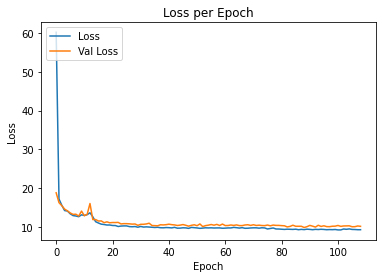

In [15]:
plot_loss([history_freeze, history_fine_tuning])

### Obtain the Train and Test Error

In [16]:
# obtain train-error
model.evaluate(train_val_data, data_path)

11.537859229123242

In [17]:
# obtain test-error
model.evaluate(test_data, data_path)

11.127773727557456

# Other Options

## 1. Grid Search for Hyperparameter Optimization

In [ ]:
from src.grid_search import grid_search

In [ ]:
param_grid = {
    "freeze_learning_rate": [1e-2],
    "freeze_batch_size": [16],
    "freeze_epochs": [1],
    "freeze_jittering_params": [(0.5, 0.5, 0.1, 1.5, 1.5)],

    "fine_tuning_learning_rate": [1e-4],
    "fine_tuning_batch_size": [16],
    "fine_tuning_epochs": [1],
    "fine_tuning_jittering_params": [(0.5, 0.5, 0.1, 1.5, 1.5), (0, 0, 0.1, 1.5, 1.5)]
}

In [ ]:
from sklearn.model_selection import train_test_split
split = train_test_split(np.arange(len(train_val_data)), train_size=1 - validation_split, 
                         test_size=validation_split, random_state=split_seed)

In [ ]:
search = grid_search(train_val_data, data_path, param_grid, cv=[split])

In [ ]:
search.best_score_

In [ ]:
search.best_params_

## 2. Transfer Learning: Bottleneck Training

In [ ]:
from src.bottleneck_features import BottleneckFeatures
import keras.backend as K
K.set_learning_phase(1)

lr_bottleneck = 1e-3
lr_freeze = 1e-3
lr_fine_tuning = 1e-4

epochs_bottleneck = 100
epochs_freeze = 10
epochs_fine_tuning = 10
batch_size = 1

out_path = None

model = TinyYoloV3()
model.replace_output_layers()
model.training_mode()

yolo_config = model.config

In [ ]:
import sklearn.model_selection

indices = list(range(len(annotation_data)))
training_indices, validation_indices = sklearn.model_selection.train_test_split(
    indices, train_size=1 - validation_split, test_size=validation_split)


training_data = {key: annotation_data[key] for i, key in enumerate(annotation_data)
                 if i in training_indices}
validation_data = {key: annotation_data[key] for i, key in enumerate(annotation_data)
                   if i in validation_indices}

### Prepare Bottleneck Features and Models

In [ ]:
bottleneck_model, last_layer_model = model.create_bottleneck_and_last_layer_model()

In [ ]:
bottleneck_features = BottleneckFeatures()
bottleneck_features.create_from_data(annotation_data, data_path, bottleneck_model, yolo_config)

train_features, val_features = bottleneck_features.train_test_split(training_indices, 
                                                                    validation_indices)

### Train Last-Layer Model on bottleneck features

In [ ]:
batch_size_bottleneck = 8

train_gen = train_features.generator(batch_size_bottleneck, yolo_config)
val_gen = val_features.generator(batch_size_bottleneck, yolo_config)
data_len = len(training_indices), len(validation_indices)
history_bottleneck = TinyYoloV3.train_model_wrapper(last_layer_model, (train_gen, val_gen), 
                                                    data_len, batch_size_bottleneck, 
                                                    lr_bottleneck, epochs_bottleneck)

### Training only the last layers with random augmented data (i.e. not bottleneck features)

In [ ]:
model.freeze(range(42)) # TODO: select what to freeze
history_freeze = model.train(training_data, validation_data, data_path, lr_freeze, 
                             batch_size, epochs_freeze, out_path=out_path, random=False)

### Final fine-tuning on all layers with lower learning rate

In [ ]:
model.unfreeze()
history_fine_tuning = model.train(training_data, validation_data, data_path, 
                                  lr_fine_tuning, batch_size, 
                                  epochs=epochs_freeze+epochs_fine_tuning, 
                                  initial_epoch=epochs_freeze, out_path=out_path, random=False)

In [ ]:
plot_loss([history_bottleneck, history_freeze, history_fine_tuning])